In [1]:
!git clone https://github.com/KushajveerSingh/ds_cup

Cloning into 'ds_cup'...
error: cannot spawn sh: No such file or directory
fatal: could not read Username for 'https://github.com': No such file or directory


In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, recall_score,precision_score,roc_curve,roc_auc_score,RocCurveDisplay
from sklearn.metrics import f1_score
smallestF =  np.finfo('float').eps # smallest float value (numpy), will be used later

In [3]:
path = Path('../data_orig')
# path = Path('ds_cup/orig_data')
orig_train_df = pd.read_csv(path/'train.csv')
orig_valid_df = pd.read_csv(path/'valid.csv')
orig_test_df = pd.read_csv(path/'test.csv')

In [4]:
#Fix Name error:
orig_train_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)
orig_valid_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)
orig_test_df.rename(columns={'auto_open_ 36_month_num': 'auto_open_36_month_num'},inplace=True)

In [5]:
def print_size(df, name):
    counts = df['Default_ind'].value_counts()
    print(f'{name} dataset')
    print(f'Num 0 values = {counts[0]}')
    print(f'Num 1 values = {counts[1]}')
    print()

In [6]:
print_size(orig_train_df, 'train')
print_size(orig_valid_df, 'valid')
print_size(orig_test_df, 'test')

train dataset
Num 0 values = 18414
Num 1 values = 1586

valid dataset
Num 0 values = 2778
Num 1 values = 222

test dataset
Num 0 values = 4599
Num 1 values = 401



In [7]:
print(orig_train_df.isnull().sum())
print('--')
print(orig_valid_df.isnull().sum())
print('--')
print(orig_test_df.isnull().sum())
print('--')

tot_credit_debt                          0
avg_card_debt                            0
credit_age                               0
credit_good_age                          0
card_age                                 0
non_mtg_acc_past_due_12_months_num       0
non_mtg_acc_past_due_6_months_num        0
mortgages_past_due_6_months_num          0
credit_past_due_amount                   0
inq_12_month_num                         0
card_inq_24_month_num                    0
card_open_36_month_num                   0
auto_open_36_month_num                   0
uti_card                                 0
uti_50plus_pct                           0
uti_max_credit_line                      0
uti_card_50plus_pct                   2055
ind_acc_XYZ                              0
rep_income                            1570
States                                   0
Default_ind                              0
dtype: int64
--
tot_credit_debt                         0
avg_card_debt                          

In [8]:
def createThreshDict(colName,Arr):
    _dict = {}
    _dict['colName'] = colName
    _dict['ThreshArr'] = Arr
    return _dict
def binColumn(col,threshArr):
    assert col.isnull().all() != True, "All values are null?"
    def binVal(val):
        loc = 1
        for x in threshArr:
            if(val<=x):
                return loc
            else:
                loc = loc+1
        return loc
    theCol = col.copy()
    threshArr = np.sort(np.array(threshArr))
    #Replace Nulls with 0 if any
    theBinnedCol = []
    for val in theCol:
        if(not np.isnan(val)):
            theBinnedCol.extend([binVal(val)])
        else:
            theBinnedCol.extend([0])
        #theCol.update(pd.Series([], index=[ind]))
    return pd.Series(theBinnedCol,index=col.keys())

In [9]:
def trainDataBinClean(DF):
    DFThresh =  pd.DataFrame(columns=createThreshDict("",[]).keys())
    DF_Cleaned = pd.DataFrame(columns=DF.columns)
    #--'tot_credit_debt'--
    _col = 'tot_credit_debt'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'avg_card_debt'--
    cutoff_avg_card_debt = (13167.825020 + 99999.0)/2
    _col = 'avg_card_debt'
    _thresh = DF[DF.avg_card_debt < cutoff_avg_card_debt]['avg_card_debt'].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    _thresh = np.append(_thresh, [cutoff_avg_card_debt])
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'credit_age'--
    _col = 'credit_age'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'credit_good_age'--
    _col = 'credit_good_age'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'card_age'--
    _col = 'card_age'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'non_mtg_acc_past_due_12_months_num'--
    DF_Cleaned['non_mtg_acc_past_due_12_months_num'] = DF['non_mtg_acc_past_due_12_months_num'].copy()
    #--'non_mtg_acc_past_due_6_months_num'--
    DF_Cleaned['non_mtg_acc_past_due_6_months_num'] = DF['non_mtg_acc_past_due_6_months_num'].copy()
    #--'mortgages_past_due_6_months_num'--
    DF_Cleaned['mortgages_past_due_6_months_num'] = DF['mortgages_past_due_6_months_num'].copy()
    #--'credit_past_due_amount'--
    _col = 'credit_past_due_amount'
    _thresh = DF[DF.credit_past_due_amount > 0][_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    _thresh = np.insert(_thresh, 0, 0+smallestF)
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'inq_12_month_num'--
    _col = 'inq_12_month_num'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'card_inq_24_month_num'--
    _col = 'card_inq_24_month_num'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'card_open_36_month_num'--
    _col = 'card_open_36_month_num'
    DF_Cleaned[_col] = DF[_col].copy()
    #--'auto_open_ 36_month_num'--
    _col = 'auto_open_36_month_num'
    DF_Cleaned[_col] = DF[_col].copy()
    #--'uti_card'--
    _col = 'uti_card'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'uti_50plus_pct'--
    _col = 'uti_50plus_pct'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'uti_max_credit_line'--
    _col = 'uti_max_credit_line'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'uti_card_50plus_pct'--
    _col = 'uti_card_50plus_pct'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'ind_acc_XYZ'--
    _col = 'ind_acc_XYZ'
    DF_Cleaned[_col] = DF[_col].copy()
    #--'rep_income'--
    _col = 'rep_income'
    _thresh = DF[_col].quantile([0.2,0.4,0.6,0.8]).to_numpy()
    DFThresh = DFThresh.append(createThreshDict(_col,
        _thresh),
        ignore_index=True) 
    DF_Cleaned[_col] = binColumn(DF[_col],_thresh)
    #--'States'--
    _col = 'States'
    enc = OneHotEncoder(handle_unknown='ignore',sparse = False)
    SM = enc.fit_transform(DF[_col].to_numpy().reshape(-1,1)) #Got it!
    for ind,cat in zip(range(0,len(enc.categories_[0])),enc.categories_[0]):
        DF_Cleaned.drop(columns=['is'+str(cat)],inplace=True,errors='ignore')
        DF_Cleaned.insert(0,'is'+str(cat), SM[:,ind]) # Inserted column names are isAK, isAL, isDC..etc. 
    #And it will contain 0 if that is not the state and 1 if that is the state,
    DF_Cleaned.drop(columns=[_col],inplace=True) #Remove States Column
    #--'Default_ind'--
    _col = 'Default_ind'
    DF_Cleaned[_col] = DF[_col].copy()
    #--
    return DF_Cleaned,DFThresh

In [10]:
def binDataFrameWithThresh(DF,ThreshDF):
    DF_Cleaned = DF.copy()
    for col,arr in zip(ThreshDF.colName.values,ThreshDF.ThreshArr.values):
        DF_Cleaned[col] = binColumn(DF[col],arr)
    return DF_Cleaned
def oneHotEncodeStates(DF):
    _col = 'States'
    DF_Fixed = DF.copy()
    enc = OneHotEncoder(handle_unknown='ignore',sparse = False)
    SM = enc.fit_transform(DF[_col].to_numpy().reshape(-1,1)) #Got it!
    for ind,cat in zip(range(0,len(enc.categories_[0])),enc.categories_[0]):
        DF_Fixed.drop(columns=['is'+str(cat)],inplace=True,errors='ignore')
        DF_Fixed.insert(0,'is'+str(cat), SM[:,ind]) # Inserted column names are isAK, isAL, isDC..etc. 
    #And it will contain 0 if that is not the state and 1 if that is the state,
    DF_Fixed.drop(columns=[_col],inplace=True) #Remove States Column
    return DF_Fixed

In [11]:
df_train,df_thresh = trainDataBinClean(orig_train_df)

In [12]:
df_valid = binDataFrameWithThresh(orig_valid_df,df_thresh) # Binning Validation data using thresholds of training data
df_valid = oneHotEncodeStates(df_valid) #States
#Same ops on test data
df_test = binDataFrameWithThresh(orig_test_df,df_thresh)
df_test = oneHotEncodeStates(df_test)

In [13]:
#train_df.to_csv(path/'train_binned.csv',index=None)
df_thresh.to_csv(path/'Thresholds.csv',index=None)

In [14]:
df_train = df_train.sample(frac=1) #Shuffle!
df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
#
df_valid = df_valid.sample(frac=1)
df_validX = df_valid.iloc[:,:-1]
df_validY = df_valid.iloc[:,-1]
#
df_test = df_test.sample(frac=1)
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

# --- Dataframes Ready ---

### Sample Logistic Regression Test

In [15]:
model = LogisticRegression(class_weight='balanced',solver='liblinear')
scores = cross_validate(model, df_trainX, df_trainY, cv=10,scoring=('accuracy','recall','precision'))

In [16]:
cv_scores = pd.DataFrame(scores)
cv_scores

,fit_time,score_time,test_accuracy,test_recall,test_precision
0,0.147036,0.004999,0.7610,0.639241,0.193487
1,0.140033,0.005000,0.7565,0.664557,0.194805
2,0.146055,0.004997,0.7660,0.727848,0.212963
3,0.133013,0.005001,0.7585,0.620253,0.188100
4,0.142033,0.005001,0.7555,0.654088,0.193309
5,0.137054,0.004996,0.7445,0.622642,0.180000
6,0.142013,0.005021,0.7630,0.584906,0.185629
7,0.105034,0.005009,0.7580,0.704403,0.204007
8,0.129050,0.004990,0.7450,0.666667,0.188277
9,0.129079,0.005019,0.7670,0.660377,0.203095


In [17]:
print('Average Cross Validation Results')
print('Accuracy =',np.average(cv_scores.test_accuracy))
print('Recall =',np.average(cv_scores.test_recall))
print('Precision =',np.average(cv_scores.test_precision))

Average Cross Validation Results
Accuracy = 0.7575000000000001
Recall = 0.6544980495183504
Precision = 0.19436709991398454


In [18]:
#checking manually

In [19]:
model2 = LogisticRegression(penalty='l1',class_weight='balanced',solver='liblinear')
hist = model2.fit(df_trainX,df_trainY)
df_validYPred = model2.predict(df_validX)
df_validYPredProba = model2.predict_proba(df_validX)

ValueError: class_weight must be dict, 'balanced', or None, got: 'auto'

In [81]:
def getMetrics(Ytrue,Ypred,YpredProb):
    accScore = accuracy_score(Ytrue,Ypred)
    recScore = recall_score(Ytrue,Ypred)
    preScore = precision_score(Ytrue,Ypred)
    print('Accuracy =',accScore)
    print('Recall =',recScore)
    print('Precision =',preScore)
    print('--------------------------')
    print('Confusion Matrix')
    print(pd.crosstab(pd.Series(Ytrue.values,name='Actual'),pd.Series(Ypred,name='Predicted')))
    print('--------------------------')
    print('F1 Score', f1_score(Ytrue,Ypred))
    fpr, tpr, thresholds = roc_curve(Ytrue, YpredProb, pos_label=1)
    print('Roc Auc Score = ',roc_auc_score(Ytrue,YpredProb))
    #print(fpr,tpr)
    display = RocCurveDisplay(fpr=fpr,tpr=tpr)
    display.plot()
    plt.show()

Accuracy = 0.7903333333333333
Recall = 0.6081081081081081
Precision = 0.19940915805022155
--------------------------
Confusion Matrix
Predicted   0.0  1.0
Actual              
0.0        2236  542
1.0          87  135
--------------------------
F1 Score 0.3003337041156841
Roc Auc Score =  0.7841242970832605


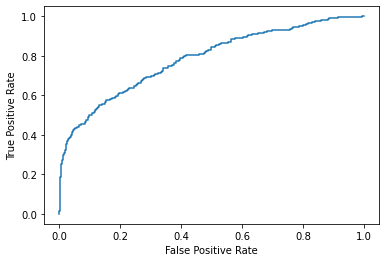

In [82]:
getMetrics(df_validY,df_validYPred,df_validYPredProba[:,-1])

In [83]:
df_validYPred

array([0., 0., 1., ..., 1., 0., 0.])

In [84]:
df_validYPredProba[:,-1]

array([0.1500221 , 0.40347927, 0.69739737, ..., 0.50173375, 0.4469705 ,
       0.22673366])